<a href="https://colab.research.google.com/github/piggyatbaqaqi/sugarbowl/blob/main/sugarbowl_jj.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from statsmodels.tsa.arima.model import ARIMA
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split


# Sugarbowl Exploratory page
**Syracuse University IST736 Summer 2025 by La Monte Henry Piggy Yarroll and JJ Balasi**

# Introduction

##Data Types and Definitions

Device

Serial Number

Device Timestamp

Record Type

Historic Glucose mg/dL

Scan Glucose mg/dL


#Data Alterations

We have removed from the data set any day that the reading taken was blank.

## Data

In [33]:
!pwd

/content


In [34]:
# Load CSV
data = pd.read_csv("La_Monte_Yarroll_glucose_7-20-2025.csv", skiprows=1)

# Clean up column names (strip spaces, unify naming)
data.columns = data.columns.str.strip()


In [35]:
# Convert timestamps to datetime
data['timestamp'] = pd.to_datetime(data['Device Timestamp'], errors='coerce')

# Convert glucose values to numeric
data['Historic Glucose mg/dL'] = pd.to_numeric(data['Historic Glucose mg/dL'], errors='coerce')

# Drop missing values
data = data.dropna(subset=['timestamp','Historic Glucose mg/dL'])

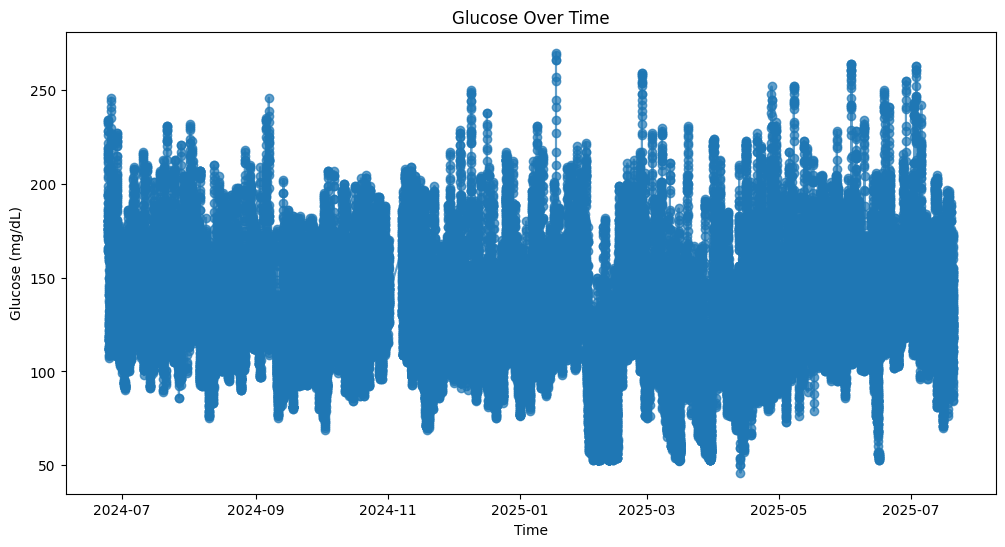

In [36]:
# Simple plot
plt.figure(figsize=(12,6))
plt.plot(data['timestamp'], data['Historic Glucose mg/dL'], marker='o', linestyle='-', alpha=0.7)
plt.xlabel("Time")
plt.ylabel("Glucose (mg/dL)")
plt.title("Glucose Over Time")
plt.show()

# Glucose vs Time — Linear vs Polynomial Regression (with comparison)

# WHAT this code does:
#   • Cleans and aligns your "timestamp" and "Historic Glucose mg/dL" columns
#   • Fits two models:
#       (1) Linear Regression (straight line)
#       (2) Polynomial Regression (degree=3) — a curved fit
#   • Compares fits using RMSE (lower is better)
#   • Plots actual data vs both model predictions

# WHY do this:
#   • Linear regression provides a simple baseline that is easy to interpret
#   • Polynomial regression captures curved trends in glucose, which are common in physiology
#   • RMSE gives an objective measure of which model fits closer to the data


Linear Regression RMSE: 27.22
Polynomial Regression (deg=3) RMSE: 26.63


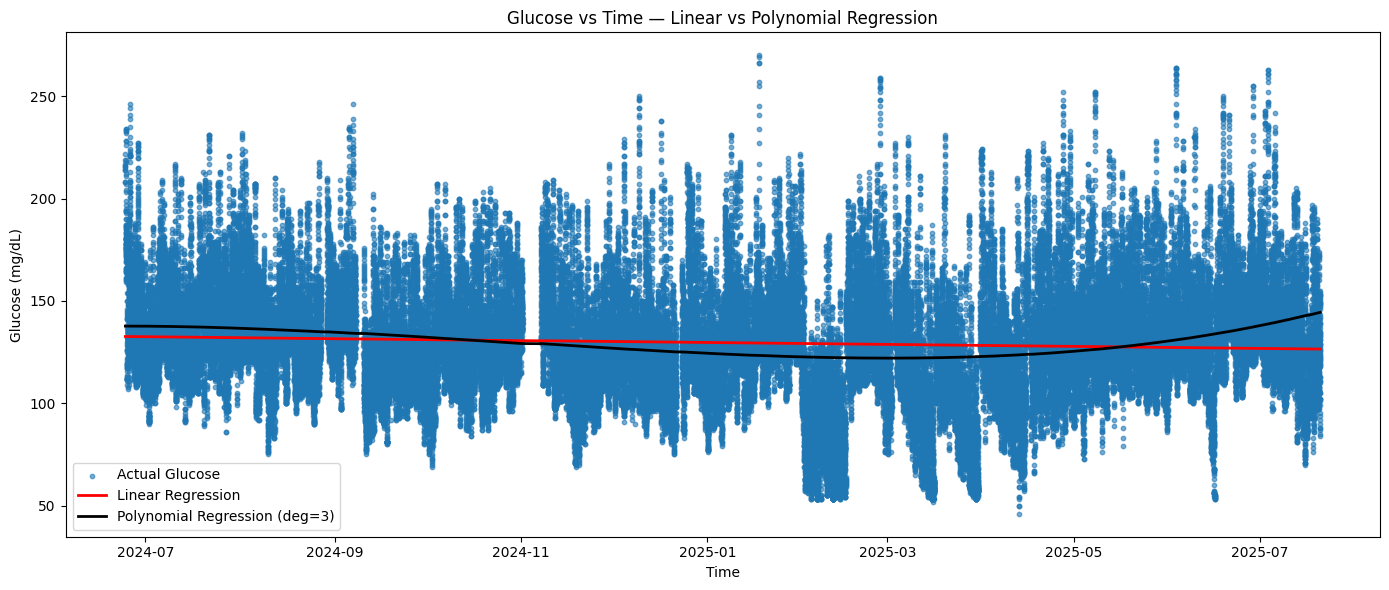

In [37]:
#  1) CLEAN + ALIGN THE DATA

y_all = pd.to_numeric(data['Historic Glucose mg/dL'], errors='coerce')
t_all = pd.to_datetime(data['timestamp'], errors='coerce')
mask = t_all.notna() & y_all.notna()
y = y_all[mask].to_numpy()
t = t_all[mask]
X = np.arange(len(t)).reshape(-1, 1)

if len(y) < 3:
    print("Not enough valid data points to fit models. Found:", len(y))
else:

    # 2) FIT THE MODELS

    lin = LinearRegression().fit(X, y)
    y_lin = lin.predict(X)

    poly = PolynomialFeatures(degree=3, include_bias=True)
    X_poly = poly.fit_transform(X)
    poly_reg = LinearRegression().fit(X_poly, y)
    y_poly = poly_reg.predict(X_poly)


    # 3) EVALUATE THE MODELS (RMSE)

    def rmse(a, b):
        a = np.asarray(a, dtype=float)
        b = np.asarray(b, dtype=float)
        return np.sqrt(np.mean((a - b) ** 2))

    rmse_lin = rmse(y, y_lin)
    rmse_poly = rmse(y, y_poly)

    print(f"Linear Regression RMSE: {rmse_lin:.2f}")
    print(f"Polynomial Regression (deg=3) RMSE: {rmse_poly:.2f}")

plt.figure(figsize=(14, 6))
plt.scatter(t, y, s=10, alpha=0.6, label='Actual Glucose')  # keep default
plt.plot(t, y_lin, linewidth=2, label='Linear Regression', color='red')
plt.plot(t, y_poly, linewidth=2, label='Polynomial Regression (deg=3)', color='black')
plt.xlabel('Time')
plt.ylabel('Glucose (mg/dL)')
plt.title('Glucose vs Time — Linear vs Polynomial Regression')
plt.legend()
plt.tight_layout()
plt.show()


In [38]:
# Define potential glucose columns and keep only those that exist
glucose_columns = [col for col in ['Scan Glucose mg/dL', 'Historic Glucose mg/dL', 'Strip Glucose mg/dL'] if col in data.columns]

In [39]:
# Use backfill to combine available glucose readings
data['Glucose Value'] = data[glucose_columns].bfill(axis=1).iloc[:, 0]
df_glucose = data.dropna(subset=['Glucose Value']).copy()
df_glucose['Glucose Value'] = pd.to_numeric(df_glucose['Glucose Value'], errors='coerce')

In [40]:
# Categorize glucose levels
def categorize_glucose(value):
    if value < 70:
        return 'Low'
    elif value > 180:
        return 'High'
    else:
        return 'Normal'

df_glucose['Glucose Category'] = df_glucose['Glucose Value'].apply(categorize_glucose)

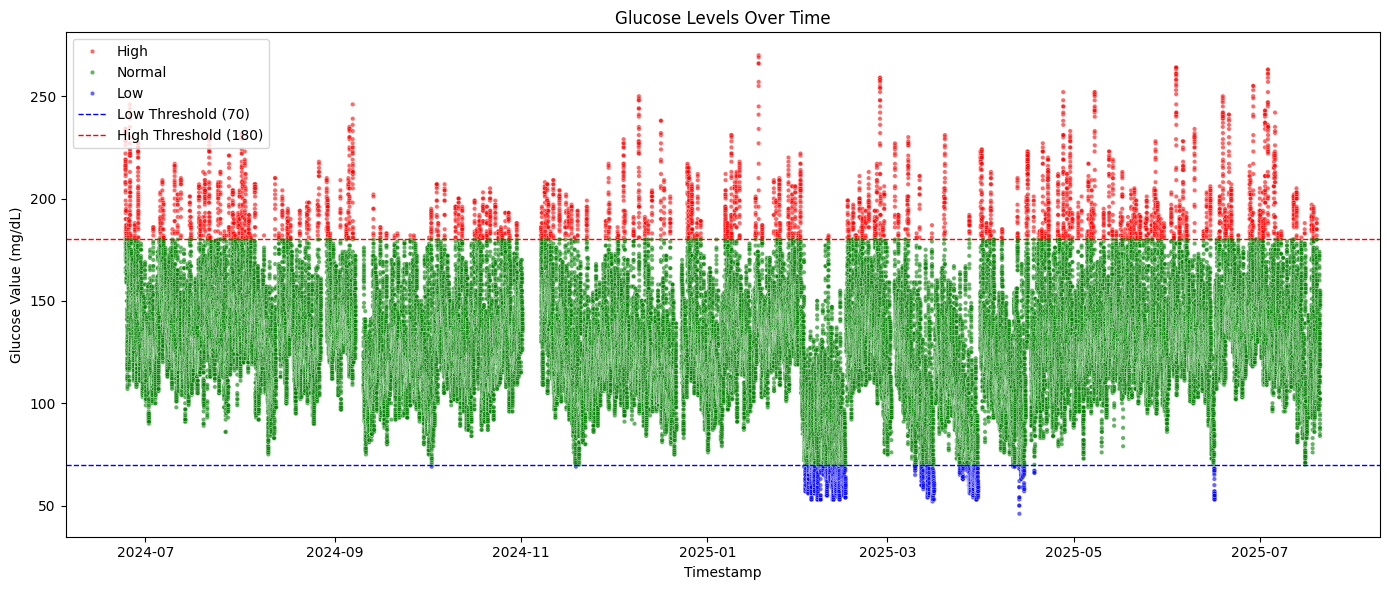

In [41]:
# Plotting Glucose Trends
df_glucose['Device Timestamp'] = pd.to_datetime(df_glucose['Device Timestamp'], errors='coerce')
df_glucose_clean = df_glucose.dropna(subset=['Device Timestamp', 'Glucose Value'])
df_glucose_clean = df_glucose_clean.sort_values(by='Device Timestamp')

plt.figure(figsize=(14, 6))
sns.scatterplot(
    data=df_glucose_clean,
    x='Device Timestamp',
    y='Glucose Value',
    hue='Glucose Category',
    palette={'Low': 'blue', 'Normal': 'green', 'High': 'red'},
    s=10,
    alpha=0.6
)
plt.axhline(70, color='blue', linestyle='--', linewidth=1, label='Low Threshold (70)')
plt.axhline(180, color='red', linestyle='--', linewidth=1, label='High Threshold (180)')
plt.title('Glucose Levels Over Time')
plt.xlabel('Timestamp')
plt.ylabel('Glucose Value (mg/dL)')
plt.legend()
plt.tight_layout()
plt.show()

trying to predict the glycemic indicator take first number subtract senconds over the next two hours

usse vectorizer, remove stopwords, resturant names end with a colon do word clouds and stuff

## Methods and Models

Algorithms Used:
- Backfill Imputation: Fills missing glucose readings from alternate sources.
- Rule-Based Classification: Categorizes glucose levels using thresholds.
- Keyword Matching: Tags notes with contextual labels based on key terms.
- Scatter Plot: Visual representation of glucose levels over time.
- Decision Tree Classifier: Predicts glucose category using glucose values.
- Support Vector Machine (SVM): Alternative classifier for glucose categories.
- ARIMA Forecasting: Predicts future glucose values using time series modeling.
- TF-IDF + KMeans: Clusters textual notes into semantic groups.

## Results and Observations

## Experimental Design and Investigation Strategy

## Conclusions

## Appendix

## Bibliography